In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm
import pickle

import robustness_model

/Users/sang-geon/Documents/UCI_BIASLab/HDC_Robustness/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.MNIST(root = './datasets/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './datasets/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [3]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

In [4]:
X_train = X_train[(y_train == 0) | (y_train == 1)].reshape(-1, 28*28) / 255
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_test = X_test[(y_test == 0) | (y_test == 1)].reshape(-1, 28*28) / 255
y_test = y_test[(y_test == 0) | (y_test == 1)]

In [5]:
original_dim = 28*28
dim = 10000

In [6]:
def overall_robustness_method3(model: robustness_model.ClassificationModel, X):
    
    ep3s = []

    max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=2000)

    for x in X:
        ep3 = model.get_eps(x, L3)
        ep3s.append(ep3)
    
    return torch.tensor(ep3s).mean()

In [7]:
dists = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
samples = dists.sample(sample_shape=torch.Size((dim, original_dim)))[:, :, 0] # w/o batch

In [8]:
dists = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
samples = dists.sample(sample_shape=torch.Size((dim, original_dim))) # w/o batch
dists.log_prob(samples).shape, samples.shape

(torch.Size([10000, 784, 1]), torch.Size([10000, 784, 1]))

In [9]:
samples.shape

torch.Size([10000, 784, 1])

In [10]:
encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_train, y_train)

preds = model.predict(X_train)
(preds == y_train).sum() / len(y_train)

tensor(0.8388)

In [15]:
overall_robustness_method3(model, X_train)

100%|██████████| 10000/10000 [00:36<00:00, 274.85it/s]


tensor(0.0170)

In [44]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


sample_size = 3
lr=0.0001

theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs()) # theta = (0, sigma) = (sigma)
optimizer = torch.optim.Adam([theta], lr=lr)

loss_history = []
theta_history = []
epsilon_history = []

for i in range(30):

    optimizer.zero_grad()

    dists = torch.distributions.Normal(0.0, theta)
    samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
    
    epsilons = []
    for sample in samples:
        encoder = robustness_model.FHRREncoder(original_dim, dim, M=sample)
        model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
        model.bundling(X_test, y_test) # X_train, y_train

        epsilon = overall_robustness_method3(model, X_test) # X_train
        epsilons.append(epsilon)
    epsilons = torch.tensor(epsilons)

    # REINFORCE
    loss = sum(epsilon.item() * dists.log_prob(sample) for epsilon, sample in zip(epsilons, samples))
    loss = -loss.mean()
    loss.backward()

    optimizer.step()

    loss_history.append(loss.item())
    theta_history.append(theta.item())
    epsilon_history.append(epsilons.mean().item())

    print(i, loss.item(), epsilons.mean())


100%|██████████| 2000/2000 [00:07<00:00, 260.85it/s]


0 -0.23580235242843628 tensor(1.1600)


100%|██████████| 2000/2000 [00:07<00:00, 277.22it/s]


1 -0.24052344262599945 tensor(1.1773)


100%|██████████| 2000/2000 [00:07<00:00, 276.26it/s]


2 -0.23830977082252502 tensor(1.1624)


100%|██████████| 2000/2000 [00:07<00:00, 281.87it/s]


3 -0.24112066626548767 tensor(1.1728)


100%|██████████| 2000/2000 [00:07<00:00, 283.17it/s]


4 -0.2406676709651947 tensor(1.1657)


100%|██████████| 2000/2000 [00:07<00:00, 280.94it/s]


5 -0.24298766255378723 tensor(1.1735)


100%|██████████| 2000/2000 [00:07<00:00, 280.98it/s]


6 -0.24134254455566406 tensor(1.1617)


100%|██████████| 2000/2000 [00:07<00:00, 280.90it/s]


7 -0.24326469004154205 tensor(1.1742)


100%|██████████| 2000/2000 [00:07<00:00, 280.39it/s]


8 -0.24304445087909698 tensor(1.1671)


100%|██████████| 2000/2000 [00:07<00:00, 282.49it/s]


9 -0.2444460690021515 tensor(1.1737)


100%|██████████| 2000/2000 [00:07<00:00, 278.29it/s]


10 -0.2428765445947647 tensor(1.1636)


100%|██████████| 2000/2000 [00:07<00:00, 282.34it/s]


11 -0.24521993100643158 tensor(1.1761)


100%|██████████| 2000/2000 [00:07<00:00, 279.04it/s]


12 -0.24305997788906097 tensor(1.1648)


100%|██████████| 2000/2000 [00:07<00:00, 281.52it/s]


13 -0.24494758248329163 tensor(1.1713)


100%|██████████| 2000/2000 [00:07<00:00, 279.76it/s]


14 -0.2428513914346695 tensor(1.1665)


100%|██████████| 2000/2000 [00:07<00:00, 282.94it/s]


15 -0.24368692934513092 tensor(1.1675)


100%|██████████| 2000/2000 [00:07<00:00, 258.42it/s]


16 -0.2446209341287613 tensor(1.1680)


100%|██████████| 2000/2000 [00:07<00:00, 284.60it/s]


17 -0.2417910099029541 tensor(1.1607)


100%|██████████| 2000/2000 [00:07<00:00, 284.05it/s]


18 -0.24213095009326935 tensor(1.1645)


100%|██████████| 2000/2000 [00:07<00:00, 284.89it/s]


19 -0.24361471831798553 tensor(1.1654)


100%|██████████| 2000/2000 [00:06<00:00, 286.15it/s]


20 -0.2430054247379303 tensor(1.1679)


100%|██████████| 2000/2000 [00:06<00:00, 288.18it/s]


21 -0.24575532972812653 tensor(1.1831)


100%|██████████| 2000/2000 [00:07<00:00, 282.66it/s]


22 -0.24276122450828552 tensor(1.1693)


100%|██████████| 2000/2000 [00:06<00:00, 289.60it/s]


23 -0.24230577051639557 tensor(1.1727)


100%|██████████| 2000/2000 [00:07<00:00, 269.06it/s]


24 -0.2405194491147995 tensor(1.1628)


100%|██████████| 2000/2000 [00:07<00:00, 279.43it/s]


25 -0.24389034509658813 tensor(1.1820)


100%|██████████| 2000/2000 [00:07<00:00, 280.52it/s]


26 -0.24124129116535187 tensor(1.1659)


100%|██████████| 2000/2000 [00:07<00:00, 281.85it/s]


27 -0.24214361608028412 tensor(1.1788)


100%|██████████| 2000/2000 [00:07<00:00, 276.35it/s]


28 -0.2410275936126709 tensor(1.1762)


100%|██████████| 2000/2000 [00:07<00:00, 282.91it/s]


29 -0.23936042189598083 tensor(1.1630)


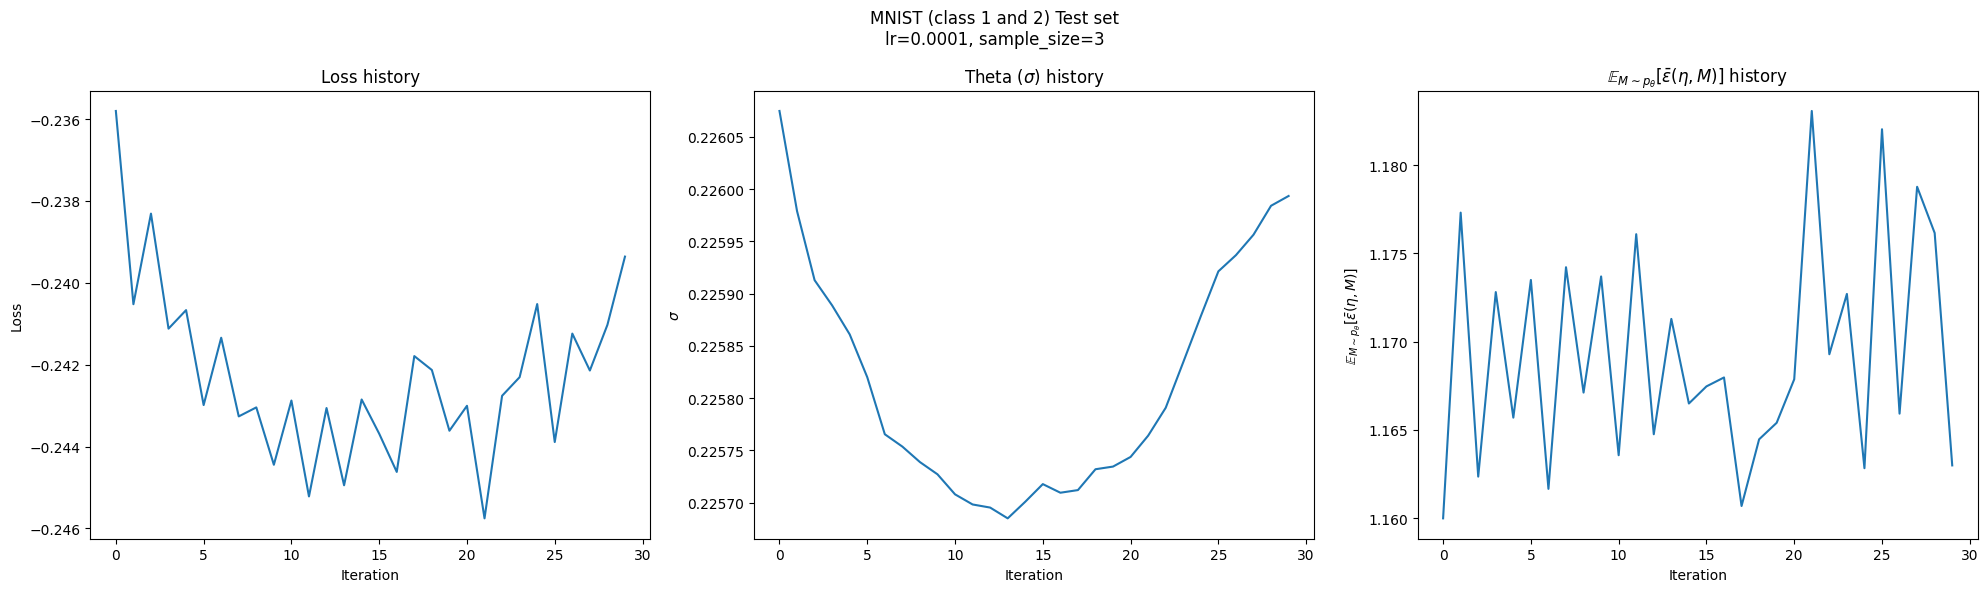

In [45]:
fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
axes[0].set_title('Loss history')
axes[0].plot(loss_history)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[1].set_title('Theta ($\sigma$) history')
axes[1].plot(theta_history)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$\sigma$')
axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
axes[2].plot(epsilon_history)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
fig.tight_layout()
plt.show()

In [46]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


sample_size = 10
lr=0.0001

theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs()) # theta = (0, sigma) = (sigma)
optimizer = torch.optim.Adam([theta], lr=lr)

loss_history = []
theta_history = []
epsilon_history = []

for i in range(30):

    optimizer.zero_grad()

    dists = torch.distributions.Normal(0.0, theta)
    samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
    
    epsilons = []
    for sample in samples:
        encoder = robustness_model.FHRREncoder(original_dim, dim, M=sample)
        model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
        model.bundling(X_test, y_test) # X_train, y_train

        epsilon = overall_robustness_method3(model, X_test) # X_train
        epsilons.append(epsilon)
    epsilons = torch.tensor(epsilons)

    # REINFORCE
    loss = sum(epsilon.item() * dists.log_prob(sample) for epsilon, sample in zip(epsilons, samples))
    loss = -loss.mean()
    loss.backward()

    optimizer.step()

    loss_history.append(loss.item())
    theta_history.append(theta.item())
    epsilon_history.append(epsilons.mean().item())

    print(i, loss.item(), epsilons.mean())


100%|██████████| 2000/2000 [00:07<00:00, 275.93it/s]


0 1.527684211730957 tensor(0.6313)


100%|██████████| 2000/2000 [00:07<00:00, 279.07it/s]


1 1.5273290872573853 tensor(0.6322)


100%|██████████| 2000/2000 [00:07<00:00, 279.81it/s]


2 1.5252004861831665 tensor(0.6319)


100%|██████████| 2000/2000 [00:07<00:00, 279.06it/s]


3 1.510138988494873 tensor(0.6263)


100%|██████████| 2000/2000 [00:07<00:00, 279.33it/s]


4 1.5153392553329468 tensor(0.6292)


100%|██████████| 2000/2000 [00:07<00:00, 280.25it/s]


5 1.5155669450759888 tensor(0.6301)


100%|██████████| 2000/2000 [00:07<00:00, 279.84it/s]


6 1.5277961492538452 tensor(0.6360)


100%|██████████| 2000/2000 [00:07<00:00, 275.98it/s]


7 1.5214829444885254 tensor(0.6337)


100%|██████████| 2000/2000 [00:07<00:00, 280.34it/s]


8 1.5438613891601562 tensor(0.6438)


100%|██████████| 2000/2000 [00:07<00:00, 276.38it/s]


9 1.511581540107727 tensor(0.6305)


100%|██████████| 2000/2000 [00:07<00:00, 280.33it/s]


10 1.508345365524292 tensor(0.6299)


100%|██████████| 2000/2000 [00:07<00:00, 271.72it/s]


11 1.5278500318527222 tensor(0.6382)


100%|██████████| 2000/2000 [00:07<00:00, 269.49it/s]


12 1.5223416090011597 tensor(0.6364)


100%|██████████| 2000/2000 [00:07<00:00, 268.48it/s]


13 1.5411604642868042 tensor(0.6446)


100%|██████████| 2000/2000 [00:07<00:00, 269.94it/s]


14 1.5107425451278687 tensor(0.6324)


100%|██████████| 2000/2000 [00:07<00:00, 267.58it/s]


15 1.5318719148635864 tensor(0.6417)


100%|██████████| 2000/2000 [00:07<00:00, 267.49it/s]


16 1.5197209119796753 tensor(0.6367)


100%|██████████| 2000/2000 [00:08<00:00, 247.11it/s]


17 1.5284792184829712 tensor(0.6409)


100%|██████████| 2000/2000 [00:07<00:00, 278.81it/s]


18 1.528660535812378 tensor(0.6412)


100%|██████████| 2000/2000 [00:07<00:00, 278.44it/s]


19 1.5272070169448853 tensor(0.6412)


100%|██████████| 2000/2000 [00:07<00:00, 281.69it/s]


20 1.5056135654449463 tensor(0.6321)


100%|██████████| 2000/2000 [00:07<00:00, 278.84it/s]


21 1.5283153057098389 tensor(0.6422)


100%|██████████| 2000/2000 [00:07<00:00, 268.35it/s]


22 1.511247992515564 tensor(0.6351)


100%|██████████| 2000/2000 [00:07<00:00, 279.65it/s]


23 1.5268168449401855 tensor(0.6420)


100%|██████████| 2000/2000 [00:06<00:00, 288.50it/s]


24 1.5204211473464966 tensor(0.6395)


100%|██████████| 2000/2000 [00:07<00:00, 281.70it/s]


25 1.5048067569732666 tensor(0.6335)


100%|██████████| 2000/2000 [00:07<00:00, 281.32it/s]


26 1.5169532299041748 tensor(0.6387)


100%|██████████| 2000/2000 [00:07<00:00, 282.64it/s]


27 1.5091294050216675 tensor(0.6353)


100%|██████████| 2000/2000 [00:07<00:00, 280.92it/s]


28 1.509979009628296 tensor(0.6364)


100%|██████████| 2000/2000 [00:07<00:00, 267.09it/s]


29 1.5047250986099243 tensor(0.6342)


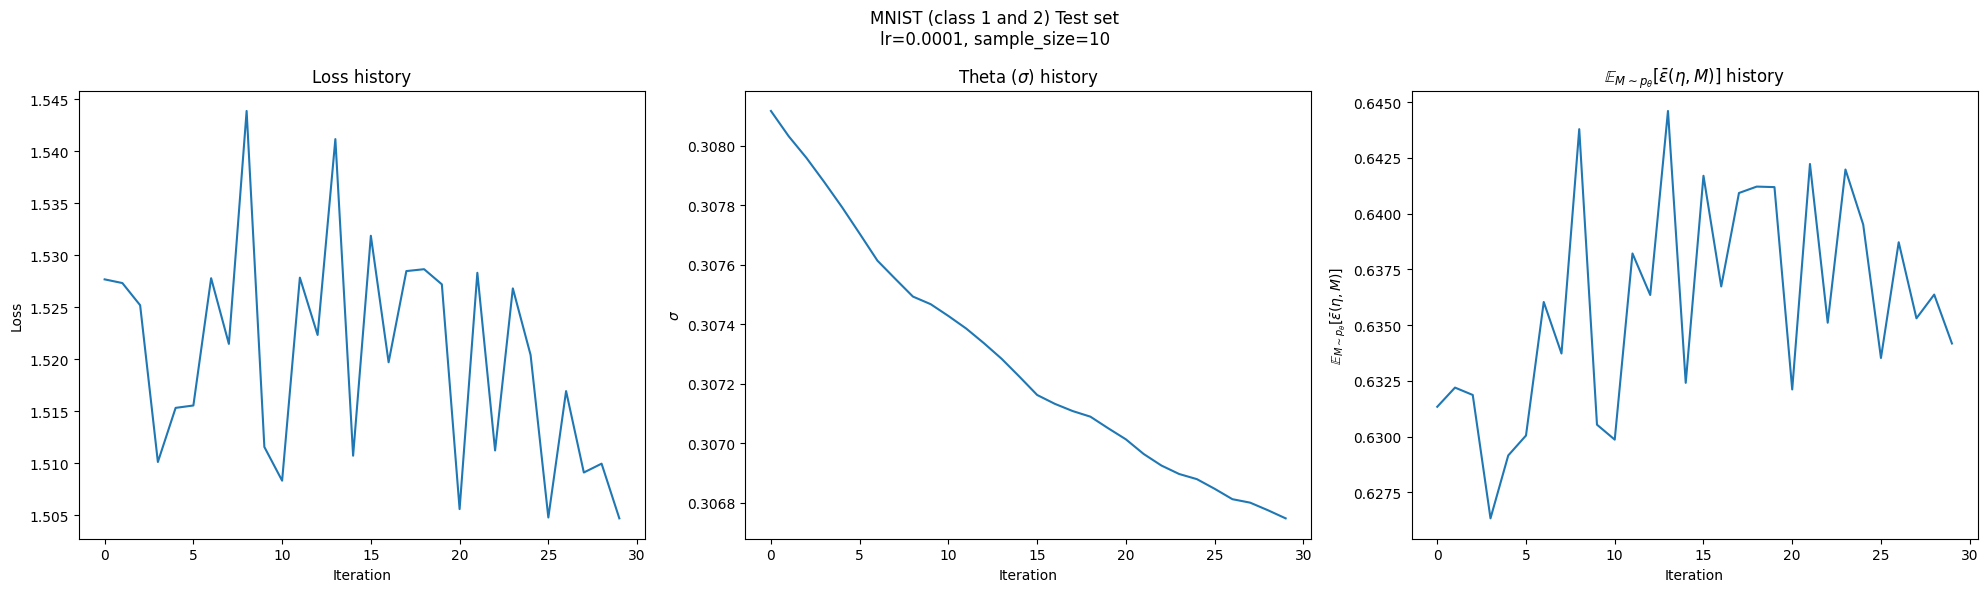

In [47]:
fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
axes[0].set_title('Loss history')
axes[0].plot(loss_history)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[1].set_title('Theta ($\sigma$) history')
axes[1].plot(theta_history)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$\sigma$')
axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
axes[2].plot(epsilon_history)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
fig.tight_layout()
plt.show()

In [48]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


sample_size = 10
lr=0.001

theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs()) # theta = (0, sigma) = (sigma)
optimizer = torch.optim.Adam([theta], lr=lr)

loss_history = []
theta_history = []
epsilon_history = []

for i in range(30):

    optimizer.zero_grad()

    dists = torch.distributions.Normal(0.0, theta)
    samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
    
    epsilons = []
    for sample in samples:
        encoder = robustness_model.FHRREncoder(original_dim, dim, M=sample)
        model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
        model.bundling(X_test, y_test) # X_train, y_train

        epsilon = overall_robustness_method3(model, X_test) # X_train
        epsilons.append(epsilon)
    epsilons = torch.tensor(epsilons)

    # REINFORCE
    loss = sum(epsilon.item() * dists.log_prob(sample) for epsilon, sample in zip(epsilons, samples))
    loss = -loss.mean()
    loss.backward()

    optimizer.step()

    loss_history.append(loss.item())
    theta_history.append(theta.item())
    epsilon_history.append(epsilons.mean().item())

    print(i, loss.item(), epsilons.mean())


100%|██████████| 2000/2000 [00:07<00:00, 267.10it/s]


0 1.3491028547286987 tensor(0.1922)


100%|██████████| 2000/2000 [00:07<00:00, 268.29it/s]


1 1.3437405824661255 tensor(0.1909)


100%|██████████| 2000/2000 [00:07<00:00, 266.76it/s]


2 1.3382834196090698 tensor(0.1899)


100%|██████████| 2000/2000 [00:07<00:00, 268.72it/s]


3 1.3472920656204224 tensor(0.1909)


100%|██████████| 2000/2000 [00:07<00:00, 271.81it/s]


4 1.3374170064926147 tensor(0.1892)


100%|██████████| 2000/2000 [00:07<00:00, 269.73it/s]


5 1.3403830528259277 tensor(0.1895)


100%|██████████| 2000/2000 [00:07<00:00, 270.60it/s]


6 1.349645972251892 tensor(0.1906)


100%|██████████| 2000/2000 [00:07<00:00, 269.11it/s]


7 1.3381627798080444 tensor(0.1888)


100%|██████████| 2000/2000 [00:07<00:00, 271.26it/s]


8 1.3274307250976562 tensor(0.1870)


100%|██████████| 2000/2000 [00:07<00:00, 270.18it/s]


9 1.3297280073165894 tensor(0.1871)


100%|██████████| 2000/2000 [00:07<00:00, 271.22it/s]


10 1.3248698711395264 tensor(0.1862)


100%|██████████| 2000/2000 [00:07<00:00, 269.04it/s]


11 1.323694109916687 tensor(0.1859)


100%|██████████| 2000/2000 [00:07<00:00, 271.23it/s]


12 1.321724534034729 tensor(0.1854)


100%|██████████| 2000/2000 [00:07<00:00, 271.31it/s]


13 1.3324484825134277 tensor(0.1867)


100%|██████████| 2000/2000 [00:07<00:00, 271.48it/s]


14 1.3258816003799438 tensor(0.1856)


100%|██████████| 2000/2000 [00:07<00:00, 269.45it/s]


15 1.3210035562515259 tensor(0.1848)


100%|██████████| 2000/2000 [00:07<00:00, 270.00it/s]


16 1.338147521018982 tensor(0.1872)


100%|██████████| 2000/2000 [00:07<00:00, 269.35it/s]


17 1.3258742094039917 tensor(0.1854)


100%|██████████| 2000/2000 [00:07<00:00, 270.76it/s]


18 1.3212571144104004 tensor(0.1847)


100%|██████████| 2000/2000 [00:07<00:00, 272.10it/s]


19 1.3225820064544678 tensor(0.1849)


100%|██████████| 2000/2000 [00:07<00:00, 271.06it/s]


20 1.3305461406707764 tensor(0.1861)


100%|██████████| 2000/2000 [00:07<00:00, 269.13it/s]


21 1.3241312503814697 tensor(0.1852)


100%|██████████| 2000/2000 [00:07<00:00, 270.45it/s]


22 1.3206818103790283 tensor(0.1848)


100%|██████████| 2000/2000 [00:07<00:00, 269.65it/s]


23 1.330631971359253 tensor(0.1862)


100%|██████████| 2000/2000 [00:07<00:00, 270.89it/s]


24 1.3264846801757812 tensor(0.1856)


100%|██████████| 2000/2000 [00:07<00:00, 268.80it/s]


25 1.3262931108474731 tensor(0.1856)


100%|██████████| 2000/2000 [00:07<00:00, 272.21it/s]


26 1.332024097442627 tensor(0.1865)


100%|██████████| 2000/2000 [00:07<00:00, 270.75it/s]


27 1.3225064277648926 tensor(0.1852)


100%|██████████| 2000/2000 [00:07<00:00, 270.90it/s]


28 1.320364236831665 tensor(0.1849)


100%|██████████| 2000/2000 [00:07<00:00, 269.39it/s]


29 1.3197230100631714 tensor(0.1848)


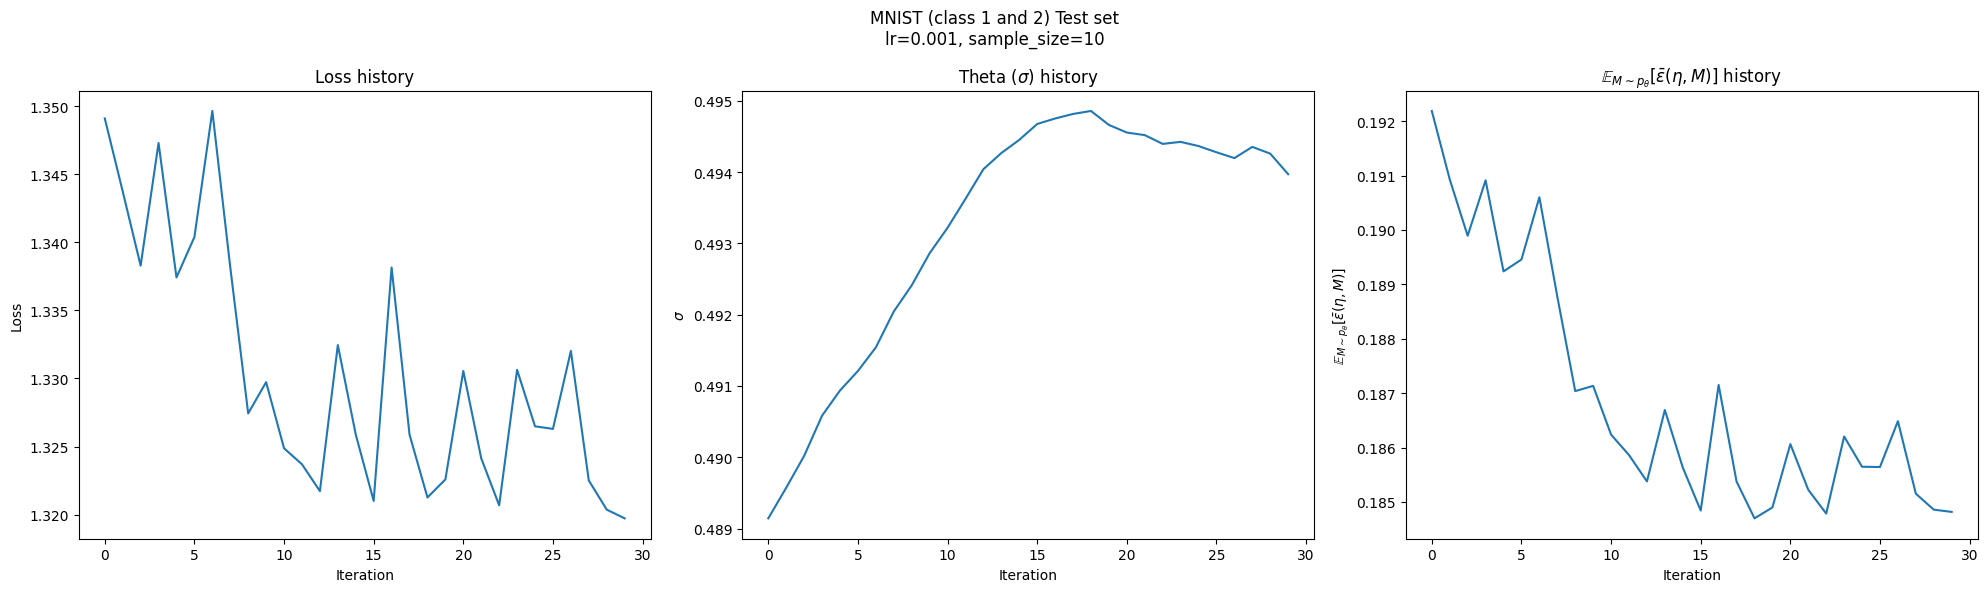

In [49]:
fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
axes[0].set_title('Loss history')
axes[0].plot(loss_history)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[1].set_title('Theta ($\sigma$) history')
axes[1].plot(theta_history)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$\sigma$')
axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
axes[2].plot(epsilon_history)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
fig.tight_layout()
plt.show()

In [57]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


sample_size = 10
lr=0.001

theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs()) # theta = (0, sigma) = (sigma)
optimizer = torch.optim.Adam([theta], lr=lr)

loss_history = []
theta_history = []
epsilon_history = []

for i in range(30):

    optimizer.zero_grad()

    dists = torch.distributions.Normal(0.0, theta)
    samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
    
    epsilons = []
    for sample in samples:
        encoder = robustness_model.FHRREncoder(original_dim, dim, M=sample)
        model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
        model.bundling(X_test, y_test) # X_train, y_train

        epsilon = overall_robustness_method3(model, X_test) # X_train
        epsilons.append(epsilon)
    epsilons = torch.tensor(epsilons)

    # REINFORCE
    loss = sum(epsilon.item() * dists.log_prob(sample).mean() for epsilon, sample in zip(epsilons, samples)) / sample_size
    loss = -loss# .mean()
    loss.backward()

    optimizer.step()

    loss_history.append(loss.item())
    theta_history.append(theta.item())
    epsilon_history.append(epsilons.mean().item())

    print(i, loss.item(), epsilons.mean())


100%|██████████| 2000/2000 [00:07<00:00, 276.85it/s]


0 -0.33285167813301086 tensor(1.4907)


100%|██████████| 2000/2000 [00:07<00:00, 274.40it/s]


1 -0.3251691162586212 tensor(1.4900)


100%|██████████| 2000/2000 [00:07<00:00, 276.57it/s]


2 -0.3297833800315857 tensor(1.4932)


100%|██████████| 2000/2000 [00:07<00:00, 279.79it/s]


3 -0.32815292477607727 tensor(1.4768)


100%|██████████| 2000/2000 [00:07<00:00, 279.09it/s]


4 -0.3343057632446289 tensor(1.4861)


100%|██████████| 2000/2000 [00:07<00:00, 276.43it/s]


5 -0.3408896327018738 tensor(1.5041)


100%|██████████| 2000/2000 [00:07<00:00, 282.13it/s]


6 -0.3412584066390991 tensor(1.4947)


100%|██████████| 2000/2000 [00:07<00:00, 257.45it/s]


7 -0.34510618448257446 tensor(1.4955)


100%|██████████| 2000/2000 [00:07<00:00, 277.93it/s]


8 -0.3518655002117157 tensor(1.5049)


100%|██████████| 2000/2000 [00:06<00:00, 295.51it/s]


9 -0.3577151894569397 tensor(1.5082)


100%|██████████| 2000/2000 [00:06<00:00, 297.53it/s]


10 -0.3639235198497772 tensor(1.5181)


100%|██████████| 2000/2000 [00:06<00:00, 297.89it/s]


11 -0.3659282922744751 tensor(1.5166)


100%|██████████| 2000/2000 [00:07<00:00, 278.74it/s]


12 -0.370263010263443 tensor(1.5223)


100%|██████████| 2000/2000 [00:08<00:00, 247.35it/s]


13 -0.3754063844680786 tensor(1.5314)


100%|██████████| 2000/2000 [00:07<00:00, 266.70it/s]


14 -0.379007488489151 tensor(1.5326)


100%|██████████| 2000/2000 [00:07<00:00, 278.35it/s]


15 -0.3845914304256439 tensor(1.5413)


100%|██████████| 2000/2000 [00:07<00:00, 272.15it/s]


16 -0.3910646438598633 tensor(1.5507)


100%|██████████| 2000/2000 [00:07<00:00, 281.40it/s]


17 -0.392768919467926 tensor(1.5505)


100%|██████████| 2000/2000 [00:07<00:00, 276.33it/s]


18 -0.3941846489906311 tensor(1.5529)


100%|██████████| 2000/2000 [00:07<00:00, 277.47it/s]


19 -0.39824697375297546 tensor(1.5649)


100%|██████████| 2000/2000 [00:07<00:00, 276.83it/s]


20 -0.40042272210121155 tensor(1.5659)


100%|██████████| 2000/2000 [00:07<00:00, 280.83it/s]


21 -0.4017813205718994 tensor(1.5678)


100%|██████████| 2000/2000 [00:07<00:00, 276.14it/s]


22 -0.39490872621536255 tensor(1.5413)


100%|██████████| 2000/2000 [00:07<00:00, 262.13it/s]


23 -0.3985918462276459 tensor(1.5533)


100%|██████████| 2000/2000 [00:07<00:00, 270.28it/s]


24 -0.4030739665031433 tensor(1.5674)


100%|██████████| 2000/2000 [00:06<00:00, 293.54it/s]


25 -0.40287986397743225 tensor(1.5622)


100%|██████████| 2000/2000 [00:07<00:00, 252.02it/s]


26 -0.404441773891449 tensor(1.5641)


100%|██████████| 2000/2000 [00:07<00:00, 284.39it/s]


27 -0.40292057394981384 tensor(1.5582)


100%|██████████| 2000/2000 [00:07<00:00, 271.96it/s]


28 -0.40364933013916016 tensor(1.5633)


100%|██████████| 2000/2000 [00:07<00:00, 281.14it/s]


29 -0.39845505356788635 tensor(1.5517)


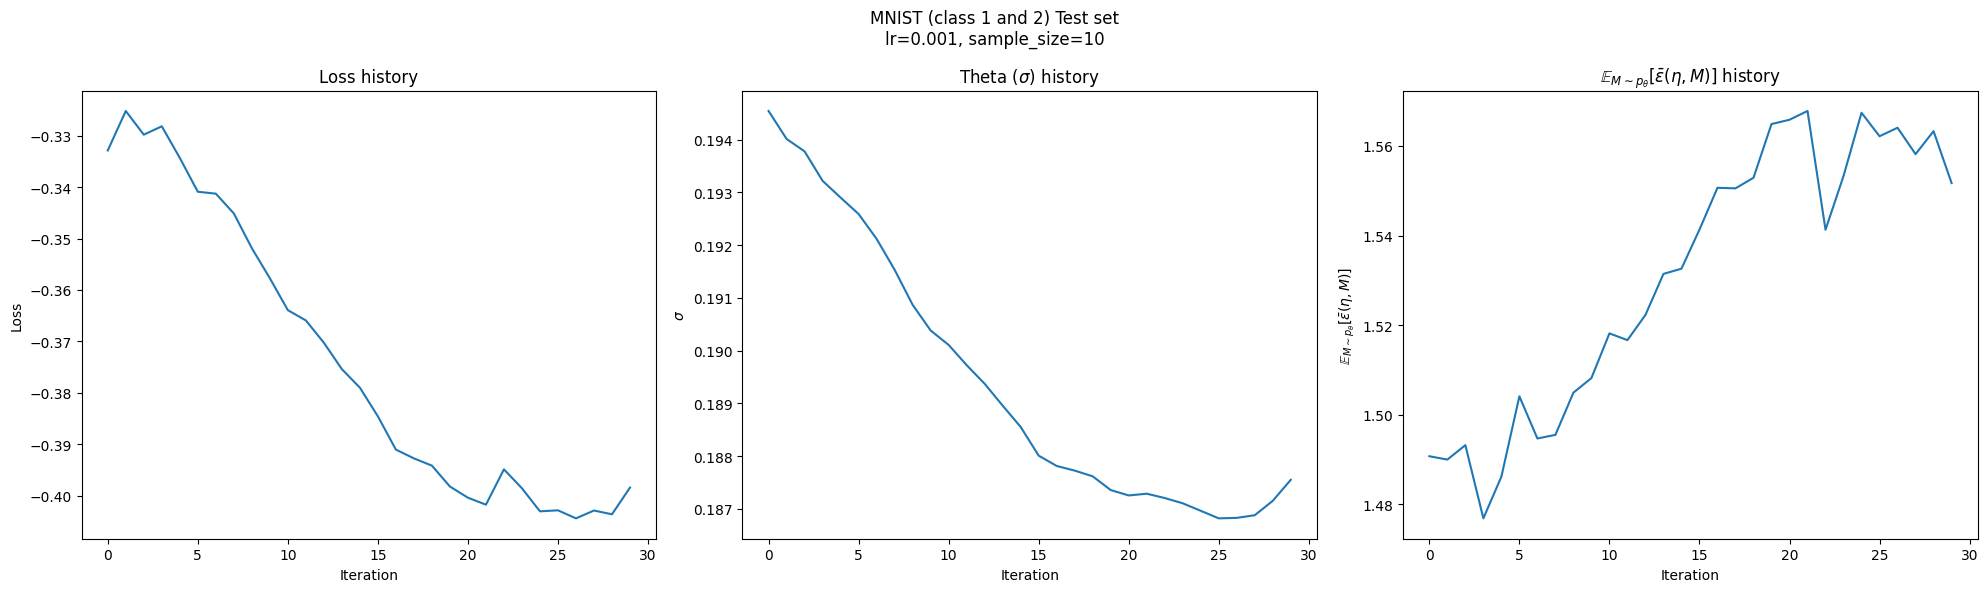

In [58]:
fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
axes[0].set_title('Loss history')
axes[0].plot(loss_history)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[1].set_title('Theta ($\sigma$) history')
axes[1].plot(theta_history)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$\sigma$')
axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
axes[2].plot(epsilon_history)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
fig.tight_layout()
plt.show()

In [59]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


sample_size = 10
lr=0.001

theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs()) # theta = (0, sigma) = (sigma)
optimizer = torch.optim.Adam([theta], lr=lr)

loss_history = []
theta_history = []
epsilon_history = []

for i in range(50):

    optimizer.zero_grad()

    dists = torch.distributions.Normal(0.0, theta)
    samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
    
    epsilons = []
    for sample in samples:
        encoder = robustness_model.FHRREncoder(original_dim, dim, M=sample)
        model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
        model.bundling(X_test, y_test) # X_train, y_train

        epsilon = overall_robustness_method3(model, X_test) # X_train
        epsilons.append(epsilon)
    epsilons = torch.tensor(epsilons)

    # REINFORCE
    loss = sum(epsilon.item() * dists.log_prob(sample).mean() for epsilon, sample in zip(epsilons, samples)) / sample_size
    loss = -loss# .mean()
    loss.backward()

    optimizer.step()

    loss_history.append(loss.item())
    theta_history.append(theta.item())
    epsilon_history.append(epsilons.mean().item())

    print(i, loss.item(), epsilons.mean())


100%|██████████| 2000/2000 [00:06<00:00, 307.20it/s]


0 0.16824659705162048 tensor(0.5122)


100%|██████████| 2000/2000 [00:07<00:00, 269.94it/s]


1 0.16940709948539734 tensor(0.5113)


100%|██████████| 2000/2000 [00:07<00:00, 273.54it/s]


2 0.16872751712799072 tensor(0.5104)


100%|██████████| 2000/2000 [00:07<00:00, 281.33it/s]


3 0.1691322773694992 tensor(0.5118)


100%|██████████| 2000/2000 [00:07<00:00, 270.25it/s]


4 0.17063260078430176 tensor(0.5153)


100%|██████████| 2000/2000 [00:07<00:00, 263.47it/s]


5 0.170192152261734 tensor(0.5128)


100%|██████████| 2000/2000 [00:06<00:00, 292.49it/s]


6 0.169160857796669 tensor(0.5083)


100%|██████████| 2000/2000 [00:07<00:00, 268.07it/s]


7 0.16909435391426086 tensor(0.5065)


100%|██████████| 2000/2000 [00:07<00:00, 267.76it/s]


8 0.17058192193508148 tensor(0.5088)


100%|██████████| 2000/2000 [00:06<00:00, 289.05it/s]


9 0.17027397453784943 tensor(0.5086)


100%|██████████| 2000/2000 [00:07<00:00, 264.50it/s]


10 0.17063310742378235 tensor(0.5115)


100%|██████████| 2000/2000 [00:07<00:00, 280.04it/s]


11 0.1685675084590912 tensor(0.5076)


100%|██████████| 2000/2000 [00:07<00:00, 274.83it/s]


12 0.17108020186424255 tensor(0.5179)


100%|██████████| 2000/2000 [00:06<00:00, 298.66it/s]


13 0.16918562352657318 tensor(0.5151)


100%|██████████| 2000/2000 [00:07<00:00, 275.99it/s]


14 0.1696915626525879 tensor(0.5194)


100%|██████████| 2000/2000 [00:07<00:00, 276.16it/s]


15 0.16868345439434052 tensor(0.5187)


100%|██████████| 2000/2000 [00:07<00:00, 273.33it/s]


16 0.1700797975063324 tensor(0.5254)


100%|██████████| 2000/2000 [00:07<00:00, 282.77it/s]


17 0.16778786480426788 tensor(0.5203)


100%|██████████| 2000/2000 [00:06<00:00, 287.91it/s]


18 0.16820688545703888 tensor(0.5235)


100%|██████████| 2000/2000 [00:07<00:00, 279.20it/s]


19 0.16723820567131042 tensor(0.5221)


100%|██████████| 2000/2000 [00:06<00:00, 286.74it/s]


20 0.16786719858646393 tensor(0.5259)


100%|██████████| 2000/2000 [00:06<00:00, 291.47it/s]


21 0.16907311975955963 tensor(0.5320)


100%|██████████| 2000/2000 [00:07<00:00, 280.74it/s]


22 0.1683553159236908 tensor(0.5322)


100%|██████████| 2000/2000 [00:07<00:00, 275.79it/s]


23 0.16773119568824768 tensor(0.5326)


100%|██████████| 2000/2000 [00:07<00:00, 273.41it/s]


24 0.16699112951755524 tensor(0.5326)


100%|██████████| 2000/2000 [00:07<00:00, 274.92it/s]


25 0.16739964485168457 tensor(0.5359)


100%|██████████| 2000/2000 [00:07<00:00, 266.14it/s]


26 0.16759347915649414 tensor(0.5383)


100%|██████████| 2000/2000 [00:06<00:00, 294.83it/s]


27 0.16584166884422302 tensor(0.5340)


100%|██████████| 2000/2000 [00:07<00:00, 281.42it/s]


28 0.16833671927452087 tensor(0.5431)


100%|██████████| 2000/2000 [00:06<00:00, 300.87it/s]


29 0.1664780080318451 tensor(0.5376)


100%|██████████| 2000/2000 [00:07<00:00, 282.07it/s]


30 0.16583168506622314 tensor(0.5358)


100%|██████████| 2000/2000 [00:07<00:00, 271.59it/s]


31 0.16689877212047577 tensor(0.5394)


100%|██████████| 2000/2000 [00:06<00:00, 298.28it/s]


32 0.1680288016796112 tensor(0.5435)


100%|██████████| 2000/2000 [00:07<00:00, 262.71it/s]


33 0.16844934225082397 tensor(0.5462)


100%|██████████| 2000/2000 [00:07<00:00, 285.13it/s]


34 0.1697545051574707 tensor(0.5522)


100%|██████████| 2000/2000 [00:06<00:00, 295.88it/s]


35 0.16644886136054993 tensor(0.5431)


100%|██████████| 2000/2000 [00:07<00:00, 284.14it/s]


36 0.16549035906791687 tensor(0.5418)


100%|██████████| 2000/2000 [00:07<00:00, 273.28it/s]


37 0.16647259891033173 tensor(0.5474)


100%|██████████| 2000/2000 [00:07<00:00, 281.03it/s]


38 0.16494572162628174 tensor(0.5454)


100%|██████████| 2000/2000 [00:06<00:00, 292.64it/s]


39 0.16530059278011322 tensor(0.5499)


100%|██████████| 2000/2000 [00:07<00:00, 268.81it/s]


40 0.16653375327587128 tensor(0.5573)


100%|██████████| 2000/2000 [00:07<00:00, 268.09it/s]


41 0.1642976999282837 tensor(0.5528)


100%|██████████| 2000/2000 [00:07<00:00, 259.89it/s]


42 0.1641739159822464 tensor(0.5552)


100%|██████████| 2000/2000 [00:07<00:00, 277.64it/s]


43 0.1643860638141632 tensor(0.5590)


100%|██████████| 2000/2000 [00:07<00:00, 272.99it/s]


44 0.16443419456481934 tensor(0.5627)


100%|██████████| 2000/2000 [00:07<00:00, 271.49it/s]


45 0.16381704807281494 tensor(0.5645)


100%|██████████| 2000/2000 [00:07<00:00, 278.33it/s]


46 0.16278287768363953 tensor(0.5646)


100%|██████████| 2000/2000 [00:06<00:00, 295.82it/s]


47 0.1627919226884842 tensor(0.5679)


100%|██████████| 2000/2000 [00:06<00:00, 294.30it/s]


48 0.16208398342132568 tensor(0.5689)


100%|██████████| 2000/2000 [00:07<00:00, 265.71it/s]


49 0.1613030731678009 tensor(0.5700)


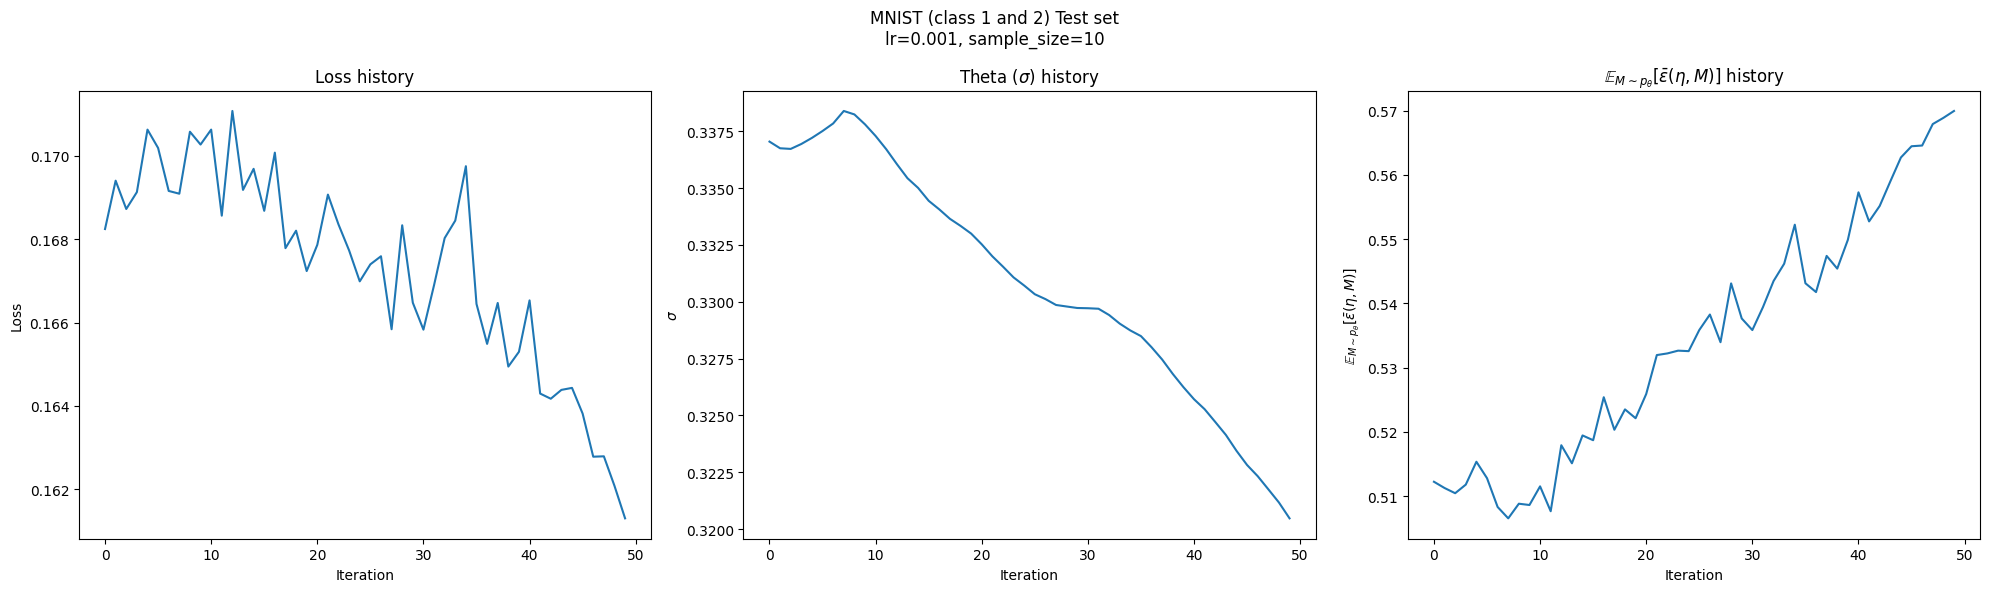

In [60]:
fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
axes[0].set_title('Loss history')
axes[0].plot(loss_history)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[1].set_title('Theta ($\sigma$) history')
axes[1].plot(theta_history)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$\sigma$')
axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
axes[2].plot(epsilon_history)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
fig.tight_layout()
plt.show()

In [61]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


sample_size = 10
lr=0.0001

theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs()) # theta = (0, sigma) = (sigma)
optimizer = torch.optim.Adam([theta], lr=lr)

loss_history = []
theta_history = []
epsilon_history = []

for i in range(50):

    optimizer.zero_grad()

    dists = torch.distributions.Normal(0.0, theta)
    samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
    
    epsilons = []
    for sample in samples:
        encoder = robustness_model.FHRREncoder(original_dim, dim, M=sample)
        model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
        model.bundling(X_test, y_test) # X_train, y_train

        epsilon = overall_robustness_method3(model, X_test) # X_train
        epsilons.append(epsilon)
    epsilons = torch.tensor(epsilons)

    # REINFORCE
    loss = sum(epsilon.item() * dists.log_prob(sample).mean() for epsilon, sample in zip(epsilons, samples)) / sample_size
    loss = -loss# .mean()
    loss.backward()

    optimizer.step()

    loss_history.append(loss.item())
    theta_history.append(theta.item())
    epsilon_history.append(epsilons.mean().item())

    print(i, loss.item(), epsilons.mean())


100%|██████████| 2000/2000 [00:08<00:00, 244.88it/s]


0 0.15957579016685486 tensor(0.5906)


100%|██████████| 2000/2000 [00:07<00:00, 270.99it/s]


1 0.15934470295906067 tensor(0.5907)


100%|██████████| 2000/2000 [00:08<00:00, 248.40it/s]


2 0.15865164995193481 tensor(0.5886)


100%|██████████| 2000/2000 [00:07<00:00, 283.84it/s]


3 0.1584455519914627 tensor(0.5880)


100%|██████████| 2000/2000 [00:07<00:00, 276.67it/s]


4 0.15911085903644562 tensor(0.5909)


100%|██████████| 2000/2000 [00:07<00:00, 278.43it/s]


5 0.15929573774337769 tensor(0.5913)


100%|██████████| 2000/2000 [00:07<00:00, 280.40it/s]


6 0.15943026542663574 tensor(0.5918)


100%|██████████| 2000/2000 [00:07<00:00, 279.36it/s]


7 0.15965044498443604 tensor(0.5929)


100%|██████████| 2000/2000 [00:07<00:00, 282.47it/s]


8 0.1591619998216629 tensor(0.5908)


100%|██████████| 2000/2000 [00:07<00:00, 262.93it/s]


9 0.15917955338954926 tensor(0.5908)


100%|██████████| 2000/2000 [00:06<00:00, 287.00it/s]


10 0.16000579297542572 tensor(0.5938)


100%|██████████| 2000/2000 [00:08<00:00, 249.02it/s]


11 0.162135511636734 tensor(0.6013)


100%|██████████| 2000/2000 [00:06<00:00, 288.87it/s]


12 0.15881818532943726 tensor(0.5892)


100%|██████████| 2000/2000 [00:06<00:00, 298.35it/s]


13 0.15945081412792206 tensor(0.5913)


100%|██████████| 2000/2000 [00:07<00:00, 278.80it/s]


14 0.16040261089801788 tensor(0.5945)


100%|██████████| 2000/2000 [00:06<00:00, 301.73it/s]


15 0.15916481614112854 tensor(0.5900)


100%|██████████| 2000/2000 [00:06<00:00, 286.68it/s]


16 0.15865980088710785 tensor(0.5878)


100%|██████████| 2000/2000 [00:07<00:00, 281.23it/s]


17 0.15945833921432495 tensor(0.5904)


100%|██████████| 2000/2000 [00:07<00:00, 280.28it/s]


18 0.1595802754163742 tensor(0.5909)


100%|██████████| 2000/2000 [00:07<00:00, 250.68it/s]


19 0.1600571721792221 tensor(0.5925)


100%|██████████| 2000/2000 [00:07<00:00, 268.73it/s]


20 0.15892189741134644 tensor(0.5881)


100%|██████████| 2000/2000 [00:06<00:00, 294.49it/s]


21 0.15869662165641785 tensor(0.5872)


100%|██████████| 2000/2000 [00:06<00:00, 297.67it/s]


22 0.15934595465660095 tensor(0.5894)


100%|██████████| 2000/2000 [00:06<00:00, 305.25it/s]


23 0.15950831770896912 tensor(0.5899)


100%|██████████| 2000/2000 [00:06<00:00, 295.83it/s]


24 0.15982654690742493 tensor(0.5912)


100%|██████████| 2000/2000 [00:06<00:00, 295.02it/s]


25 0.15957656502723694 tensor(0.5898)


100%|██████████| 2000/2000 [00:06<00:00, 302.39it/s]


26 0.15999941527843475 tensor(0.5916)


100%|██████████| 2000/2000 [00:06<00:00, 295.26it/s]


27 0.16019491851329803 tensor(0.5926)


100%|██████████| 2000/2000 [00:06<00:00, 295.95it/s]


28 0.15973541140556335 tensor(0.5906)


100%|██████████| 2000/2000 [00:06<00:00, 301.89it/s]


29 0.15909188985824585 tensor(0.5883)


100%|██████████| 2000/2000 [00:07<00:00, 279.93it/s]


30 0.1596527099609375 tensor(0.5904)


100%|██████████| 2000/2000 [00:07<00:00, 253.58it/s]


31 0.15914765000343323 tensor(0.5888)


100%|██████████| 2000/2000 [00:07<00:00, 268.68it/s]


32 0.15898622572422028 tensor(0.5883)


100%|██████████| 2000/2000 [00:06<00:00, 296.36it/s]


33 0.15946413576602936 tensor(0.5900)


100%|██████████| 2000/2000 [00:07<00:00, 268.75it/s]


34 0.15976223349571228 tensor(0.5911)


100%|██████████| 2000/2000 [00:06<00:00, 286.45it/s]


35 0.15916305780410767 tensor(0.5887)


100%|██████████| 2000/2000 [00:07<00:00, 269.10it/s]


36 0.16016151010990143 tensor(0.5925)


100%|██████████| 2000/2000 [00:07<00:00, 282.55it/s]


37 0.159938782453537 tensor(0.5915)


100%|██████████| 2000/2000 [00:07<00:00, 275.67it/s]


38 0.1594851315021515 tensor(0.5898)


100%|██████████| 2000/2000 [00:06<00:00, 290.14it/s]


39 0.16007567942142487 tensor(0.5918)


100%|██████████| 2000/2000 [00:06<00:00, 291.49it/s]


40 0.15910738706588745 tensor(0.5879)


100%|██████████| 2000/2000 [00:07<00:00, 260.53it/s]


41 0.15980328619480133 tensor(0.5905)


100%|██████████| 2000/2000 [00:07<00:00, 279.17it/s]


42 0.15986952185630798 tensor(0.5905)


100%|██████████| 2000/2000 [00:07<00:00, 257.26it/s]


43 0.15915510058403015 tensor(0.5875)


100%|██████████| 2000/2000 [00:07<00:00, 258.02it/s]


44 0.16155017912387848 tensor(0.5965)


100%|██████████| 2000/2000 [00:07<00:00, 258.18it/s]


45 0.15893976390361786 tensor(0.5867)


100%|██████████| 2000/2000 [00:07<00:00, 257.92it/s]


46 0.16031739115715027 tensor(0.5913)


100%|██████████| 2000/2000 [00:08<00:00, 232.35it/s]


47 0.162150576710701 tensor(0.5983)


100%|██████████| 2000/2000 [00:08<00:00, 241.17it/s]


48 0.1601916253566742 tensor(0.5908)


100%|██████████| 2000/2000 [00:08<00:00, 239.83it/s]


49 0.15982520580291748 tensor(0.5897)


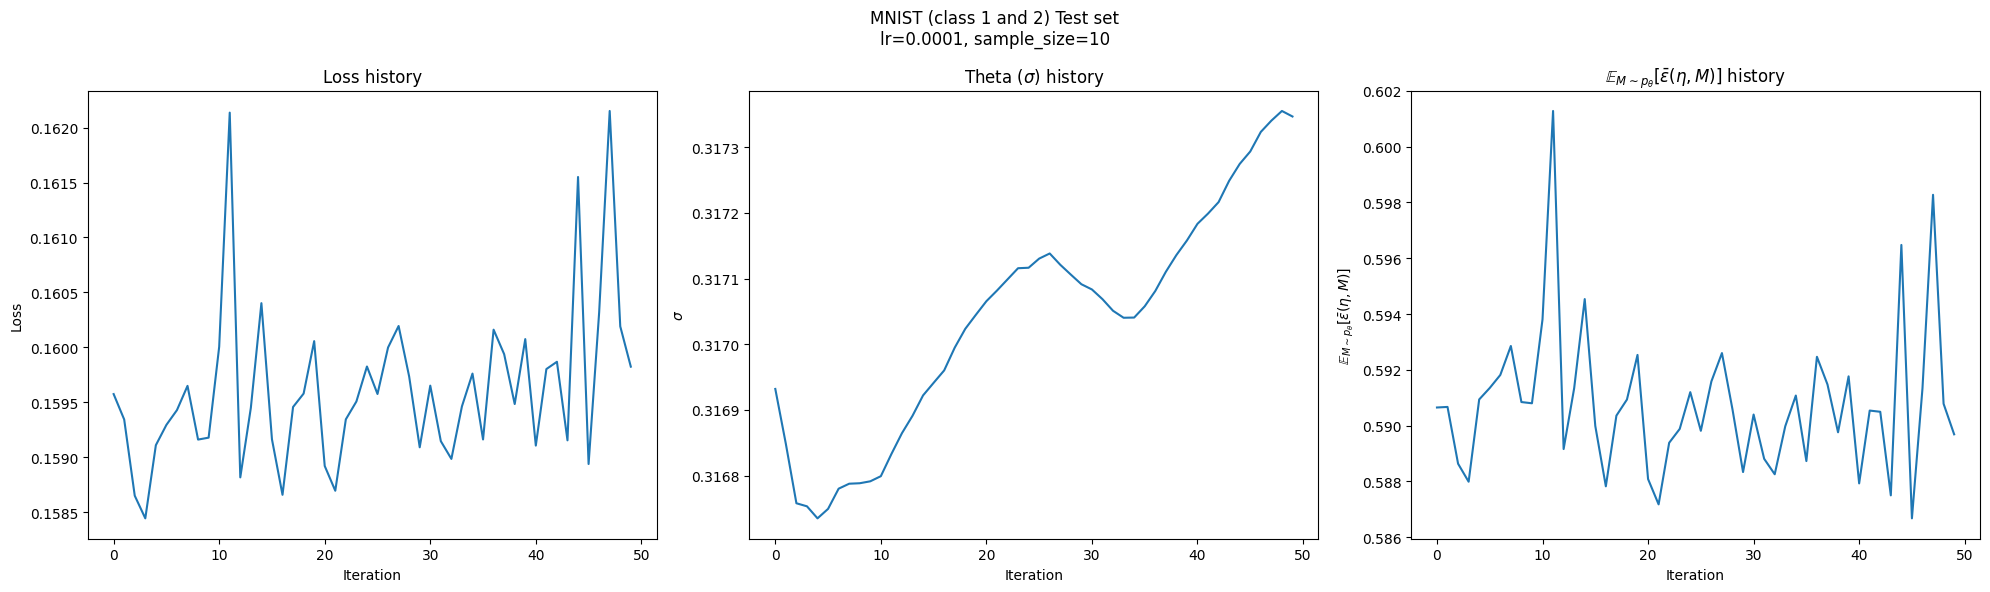

In [62]:
fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
axes[0].set_title('Loss history')
axes[0].plot(loss_history)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[1].set_title('Theta ($\sigma$) history')
axes[1].plot(theta_history)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$\sigma$')
axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
axes[2].plot(epsilon_history)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
fig.tight_layout()
plt.show()

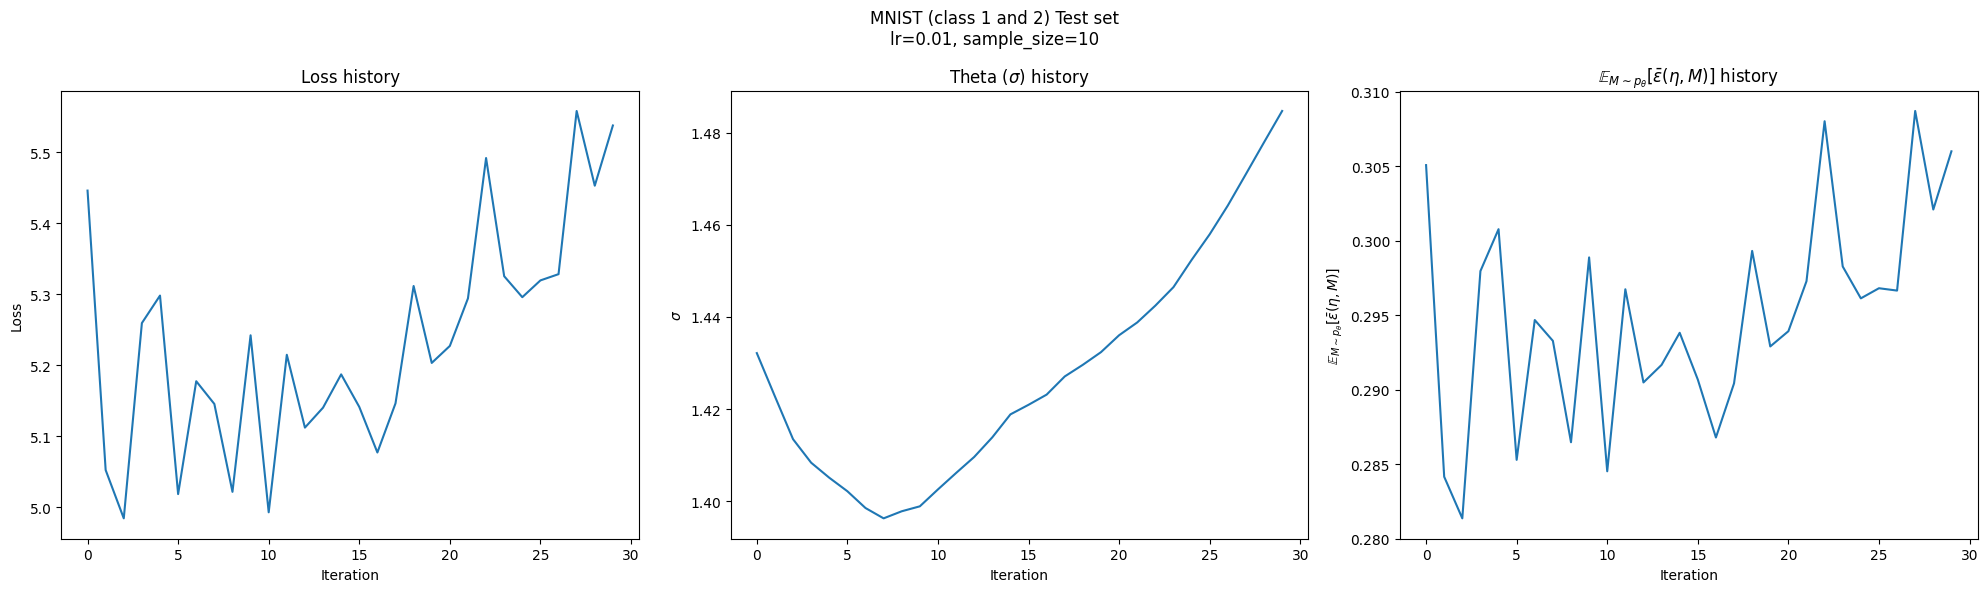

In [51]:
fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
axes[0].set_title('Loss history')
axes[0].plot(loss_history)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[1].set_title('Theta ($\sigma$) history')
axes[1].plot(theta_history)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$\sigma$')
axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
axes[2].plot(epsilon_history)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
fig.tight_layout()
plt.show()

In [52]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


sample_size = 10
lr=0.00001

theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs()) # theta = (0, sigma) = (sigma)
optimizer = torch.optim.Adam([theta], lr=lr)

loss_history = []
theta_history = []
epsilon_history = []

for i in range(30):

    optimizer.zero_grad()

    dists = torch.distributions.Normal(0.0, theta)
    samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
    
    epsilons = []
    for sample in samples:
        encoder = robustness_model.FHRREncoder(original_dim, dim, M=sample)
        model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
        model.bundling(X_test, y_test) # X_train, y_train

        epsilon = overall_robustness_method3(model, X_test) # X_train
        epsilons.append(epsilon)
    epsilons = torch.tensor(epsilons)

    # REINFORCE
    loss = sum(epsilon.item() * dists.log_prob(sample) for epsilon, sample in zip(epsilons, samples))
    loss = -loss.mean()
    loss.backward()

    optimizer.step()

    loss_history.append(loss.item())
    theta_history.append(theta.item())
    epsilon_history.append(epsilons.mean().item())

    print(i, loss.item(), epsilons.mean())


100%|██████████| 2000/2000 [00:07<00:00, 267.85it/s]


0 1.631243109703064 tensor(0.5728)


100%|██████████| 2000/2000 [00:07<00:00, 270.92it/s]


1 1.6169476509094238 tensor(0.5675)


100%|██████████| 2000/2000 [00:07<00:00, 268.74it/s]


2 1.641521692276001 tensor(0.5764)


100%|██████████| 2000/2000 [00:07<00:00, 271.57it/s]


3 1.6289746761322021 tensor(0.5720)


100%|██████████| 2000/2000 [00:07<00:00, 262.63it/s]


4 1.6176939010620117 tensor(0.5677)


100%|██████████| 2000/2000 [00:07<00:00, 268.14it/s]


5 1.6268651485443115 tensor(0.5711)


100%|██████████| 2000/2000 [00:07<00:00, 270.80it/s]


6 1.6522369384765625 tensor(0.5799)


100%|██████████| 2000/2000 [00:07<00:00, 271.09it/s]


7 1.6301205158233643 tensor(0.5721)


100%|██████████| 2000/2000 [00:07<00:00, 268.71it/s]


8 1.6356648206710815 tensor(0.5741)


100%|██████████| 2000/2000 [00:07<00:00, 270.28it/s]


9 1.63545560836792 tensor(0.5738)


100%|██████████| 2000/2000 [00:07<00:00, 269.85it/s]


10 1.63460111618042 tensor(0.5736)


100%|██████████| 2000/2000 [00:07<00:00, 270.08it/s]


11 1.626029372215271 tensor(0.5705)


100%|██████████| 2000/2000 [00:07<00:00, 270.32it/s]


12 1.6235986948013306 tensor(0.5697)


100%|██████████| 2000/2000 [00:07<00:00, 271.06it/s]


13 1.629393219947815 tensor(0.5716)


100%|██████████| 2000/2000 [00:07<00:00, 270.90it/s]


14 1.619006633758545 tensor(0.5677)


100%|██████████| 2000/2000 [00:07<00:00, 271.77it/s]


15 1.6197115182876587 tensor(0.5682)


100%|██████████| 2000/2000 [00:07<00:00, 268.35it/s]


16 1.6239265203475952 tensor(0.5699)


100%|██████████| 2000/2000 [00:07<00:00, 271.18it/s]


17 1.6207026243209839 tensor(0.5688)


100%|██████████| 2000/2000 [00:07<00:00, 271.21it/s]


18 1.6243666410446167 tensor(0.5699)


100%|██████████| 2000/2000 [00:07<00:00, 270.82it/s]


19 1.6208547353744507 tensor(0.5687)


100%|██████████| 2000/2000 [00:07<00:00, 270.53it/s]


20 1.6148356199264526 tensor(0.5664)


100%|██████████| 2000/2000 [00:07<00:00, 270.39it/s]


21 1.6315113306045532 tensor(0.5721)


100%|██████████| 2000/2000 [00:07<00:00, 269.91it/s]


22 1.6382014751434326 tensor(0.5747)


100%|██████████| 2000/2000 [00:07<00:00, 270.34it/s]


23 1.6251304149627686 tensor(0.5698)


100%|██████████| 2000/2000 [00:07<00:00, 270.61it/s]


24 1.623584508895874 tensor(0.5695)


100%|██████████| 2000/2000 [00:07<00:00, 270.55it/s]


25 1.6329476833343506 tensor(0.5727)


100%|██████████| 2000/2000 [00:07<00:00, 270.01it/s]


26 1.6274535655975342 tensor(0.5709)


100%|██████████| 2000/2000 [00:07<00:00, 270.40it/s]


27 1.6266226768493652 tensor(0.5706)


100%|██████████| 2000/2000 [00:07<00:00, 270.15it/s]


28 1.6247797012329102 tensor(0.5695)


100%|██████████| 2000/2000 [00:07<00:00, 270.88it/s]


29 1.632057547569275 tensor(0.5726)


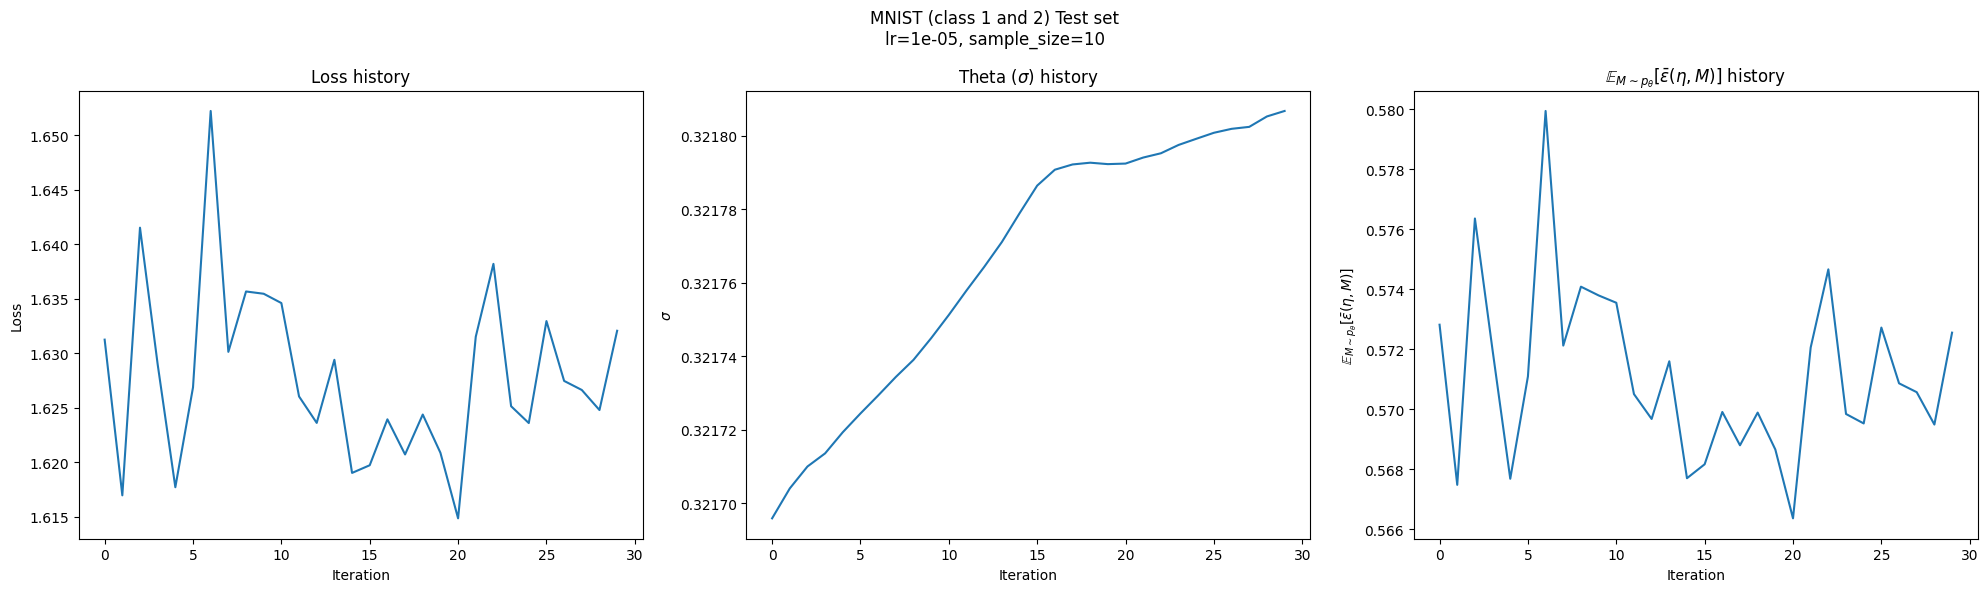

In [53]:
fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
axes[0].set_title('Loss history')
axes[0].plot(loss_history)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[1].set_title('Theta ($\sigma$) history')
axes[1].plot(theta_history)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$\sigma$')
axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
axes[2].plot(epsilon_history)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
fig.tight_layout()
plt.show()

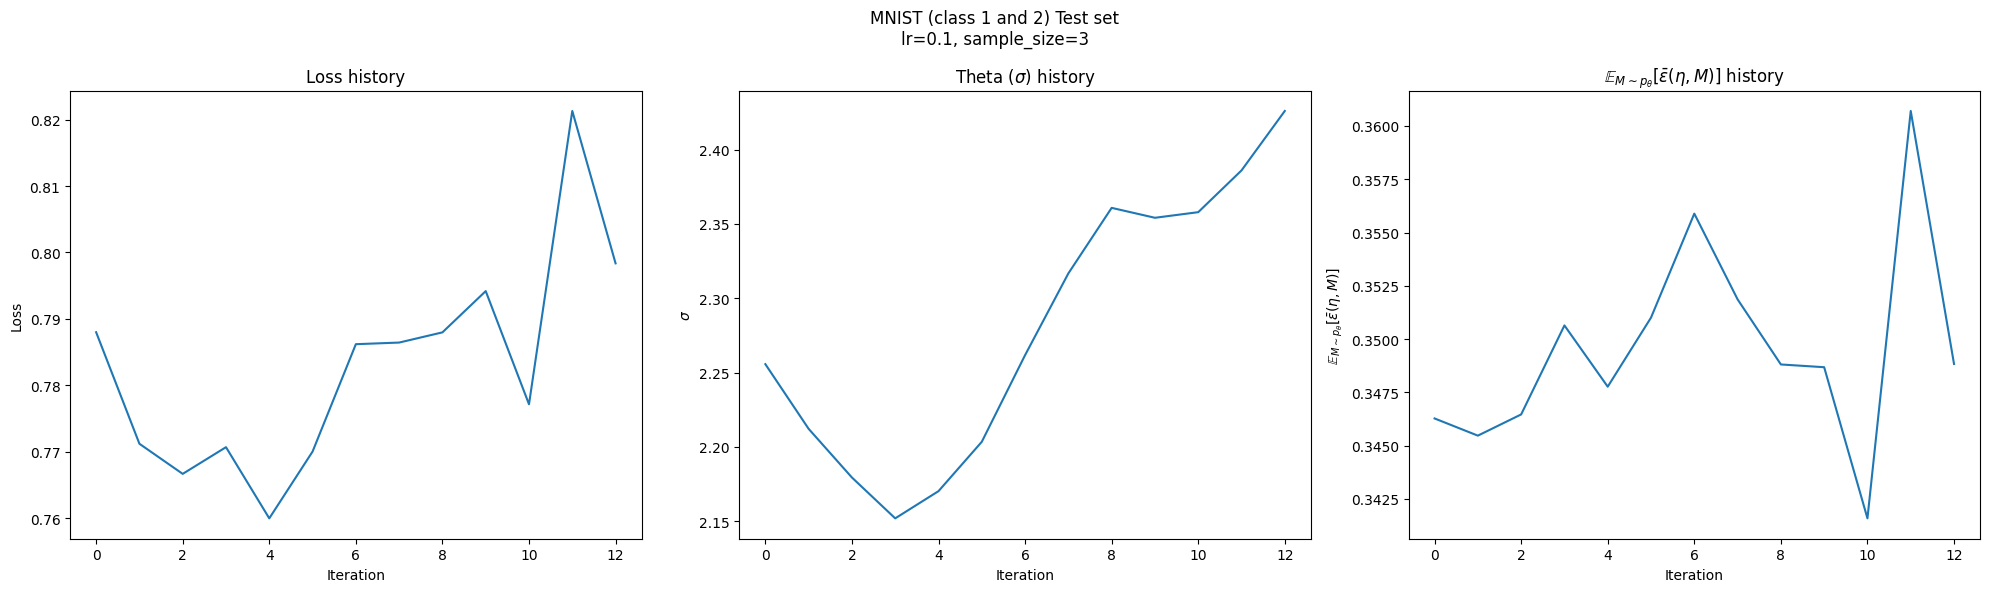

In [32]:
fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
axes[0].set_title('Loss history')
axes[0].plot(loss_history)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[1].set_title('Theta ($\sigma$) history')
axes[1].plot(theta_history)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$\sigma$')
axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
axes[2].plot(epsilon_history)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
fig.tight_layout()
plt.show()

In [33]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


sample_size = 10
lr=0.01

theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs()) # theta = (0, sigma) = (sigma)
optimizer = torch.optim.Adam([theta], lr=lr)

loss_history = []
theta_history = []
epsilon_history = []

for i in range(30):

    optimizer.zero_grad()

    dists = torch.distributions.Normal(0.0, theta)
    samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
    
    epsilons = []
    for sample in samples:
        encoder = robustness_model.FHRREncoder(original_dim, dim, M=sample)
        model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
        model.bundling(X_test, y_test) # X_train, y_train

        epsilon = overall_robustness_method3(model, X_test) # X_train
        epsilons.append(epsilon)
    epsilons = torch.tensor(epsilons)

    # REINFORCE
    loss = -epsilons.mean() * dists.log_prob(samples)
    loss = loss.mean()
    loss.backward()

    optimizer.step()

    loss_history.append(loss.item())
    theta_history.append(theta.item())
    epsilon_history.append(epsilons.mean().item())

    print(i, loss.item(), epsilons.mean())


100%|██████████| 2000/2000 [00:07<00:00, 257.51it/s]


KeyboardInterrupt: 

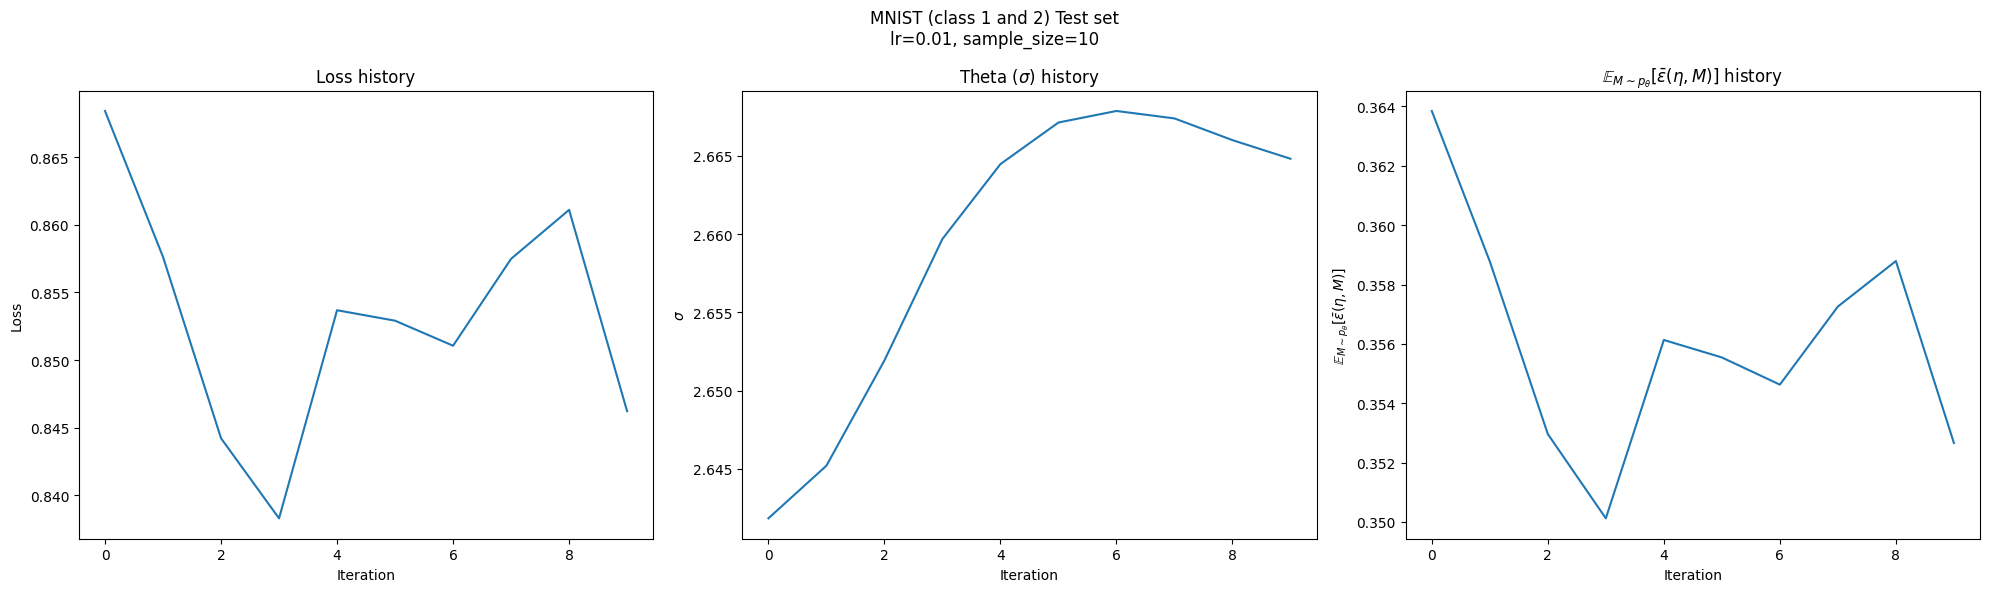

In [30]:
fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
axes[0].set_title('Loss history')
axes[0].plot(loss_history)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[1].set_title('Theta ($\sigma$) history')
axes[1].plot(theta_history)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$\sigma$')
axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
axes[2].plot(epsilon_history)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
fig.tight_layout()
plt.show()